# Variational Autoencoders

A tutorial and implementation of VAEs in PyTorch for use on the handwritten digits in the MNIST database.

References: [Paper](https://arxiv.org/abs/1312.6114), [Blog](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

## Generative Model

In contrast to other types of Autoencoders (AE) that are used for dimensionality reduction, compression or representation learning, the Variational Autoencoder (VAE) is a generative model. It not only allows the generation of random samples similar to the training data, but also allows alterations of existing samples (e.g., through interpolation or arithmetic in the encoding).

## VAE vs. AE

### Problems with the standard AE

Why are standard AEs not suitable for generative modelling? 
The fundamental problem with AEs, for generation, is that the latent space they convert their inputs to and where their encoded vectors lie, may not be continuous, or allow easy interpolation.

Consider for example the learnt embedding space of an AE trained on MNIST digits:
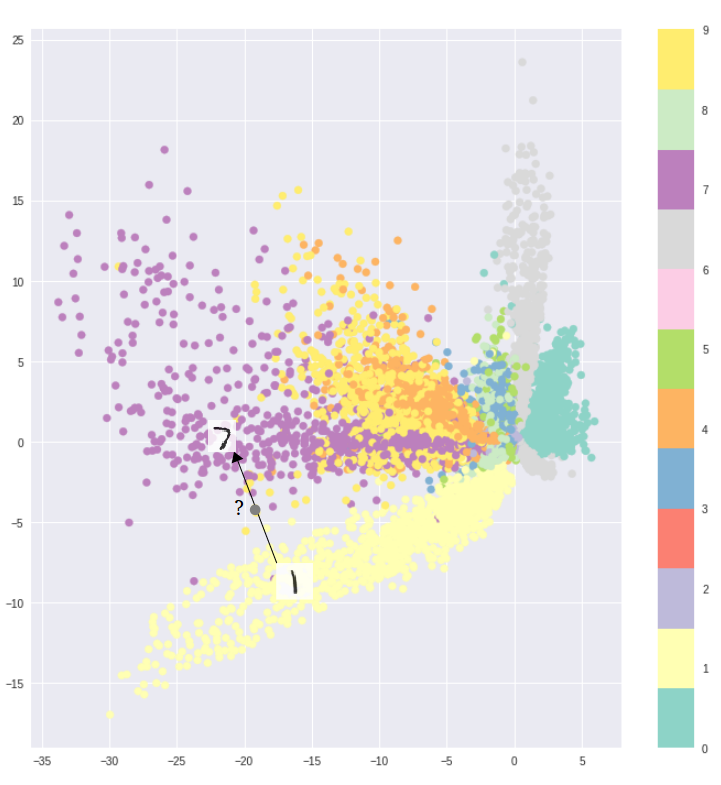

The embedding learns a clustering of the training data but the embedding space has discontinuities (i.e., gaps) between these clusters and reconstructions in these regions will lead to garbage output of the Decoder (after all it wasn't trained to reconstruct those embeddings). Manipulations in the embedding space are therefore not meaningful in the standard AE setting.

### How the VAE solves it

VAEs solve this issue by making the embedding space continous by design. It achieves this by doing something that seems rather surprising at first: making the encoder not output an encoding vector of size n, but rather, outputting two vectors of size n: a vector of means $\mu$, and another vector of standard deviations $\sigma$.

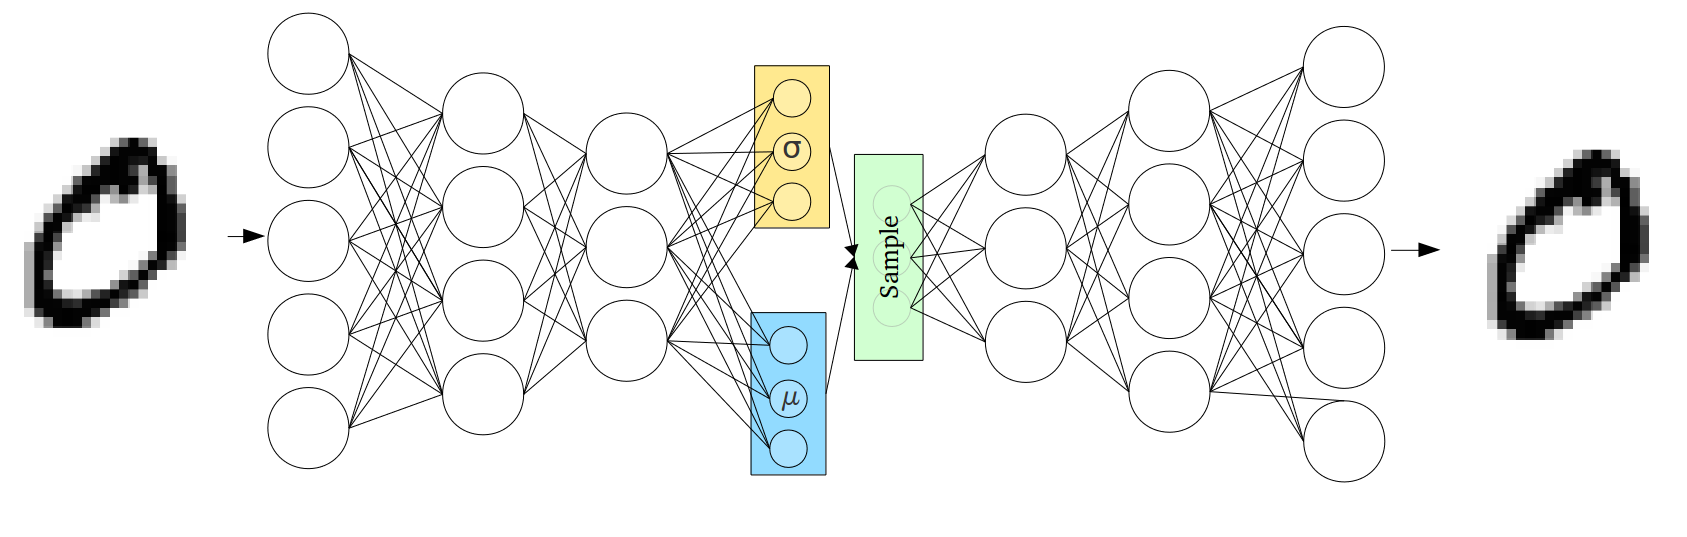

These are the paramaters of a random variable $z \sim \mathcal{N}(\mu, \sigma I)$ from which we sample and feed to the Decoder for reconstruction. This stochastic generation means, that even for the same input, while the mean and standard deviations remain the same, the actual encoding will somewhat vary on every single pass simply due to the random sampling.

Note that:
- The vector $\mu$ controls where in the embedding the encoding should be centered
- The area of the encoding is controlled by $\sigma$ (how much the encoding can vary)
- The model is exposed to a certain degree of local variation and therefore learns a smooth embedding space at least for similar examples

The model so far does however not guarantee  a globally smooth embedding space (i.e., no gaps between classes). To see this, note that the Encoder can put the $\mu$'s as far apart as it pleases and shrink the $\sigma$'s to 0: 

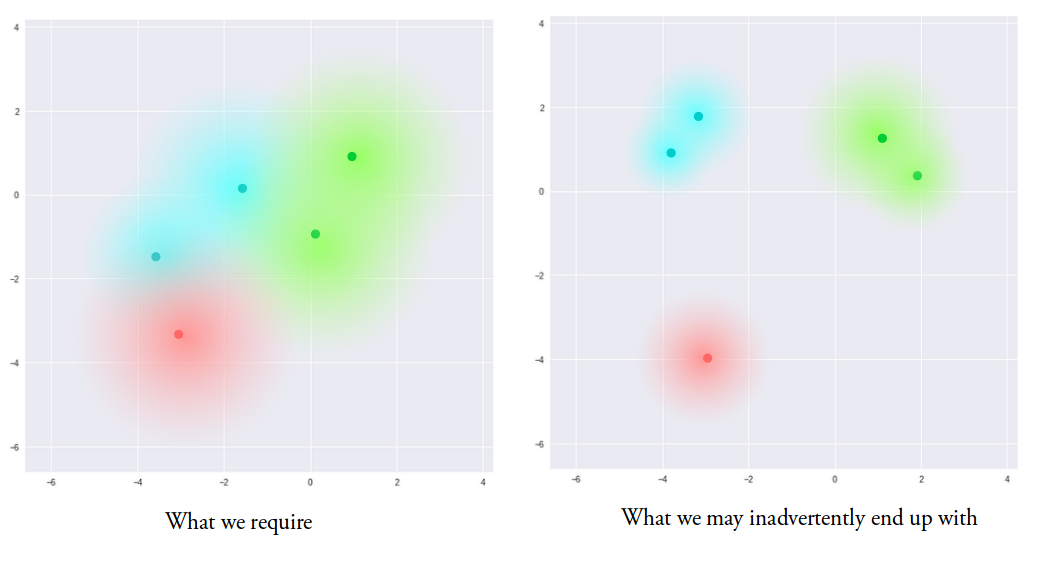

To overcome this issue we add a regularization term on the embedding based on the Kullback-Leibler divergence (KL-divergence). The KL-divergence is a similarity measure between two probability distributions $P$ and $Q$ and is defined by:

\begin{equation}
D_{KL}(P\|Q) = \int_{-\infty}^{\infty} p(x) \cdot \log \frac{p(x)}{q(x)} 
\end{equation}

### The Loss Function

We are now able to formulate the the final VAE loss function. Let $\theta$ be the parameters of the Encoder and $\phi$ the parameters of the Decoder. Let further $q_{\theta}(z|x)$ be the distibution of the encoding of $x$, $p(z)$ be the prior on the encoding space (usually a standard Normal distribution) and $p_{\phi}(x|z)$ is the reconstruction likelihood (in case of MNIST we can model pixelvalues as Bernoulli random variables, otherwise it is often modeled as a Gaussian centered around the input $x$).

The per-example loss is then given by:

\begin{equation}
l_i(\theta, \phi) = -E_{z\sim q_{\theta}(z|x)}[\log p_{\phi}(x_i|z)] + D_{KL}(q_{\theta}(z|x_i)\|p(z))
\end{equation}

The first term captures the reconstruction error and the second term is the regularization on the encoding that encourages $q_{\theta}(z|x_i)$ to be close to $p(z)$.

In our case where we model $q_{\theta}(z|x_i)$ as a Gaussian with diagonal covariance matrix and $p(z)$ as a Standard Normal the second term simplifies to:

\begin{equation}
D_{KL}(q_{\theta}(z|x_i)\|p(z)) = \sum_{i=1}^n \sigma_i²+\mu_i²-\log\sigma_i - 1
\end{equation}

The resulting embedding will look something like this:

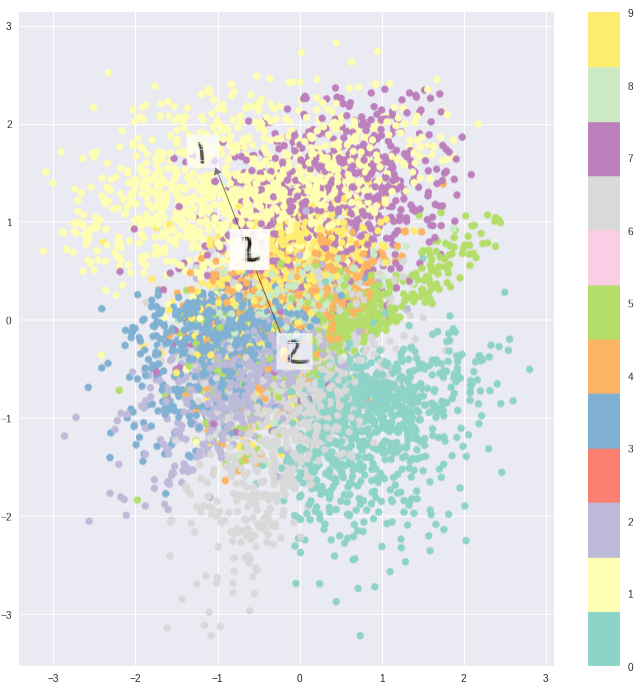

## Implementation

### Reparametrization Trick
Since the sampling of the vector $z$ can not be backprogated through we have to use the so called reparametrization trick. The idea is to sample $z$ according to a Standard Normal and then transforming it using the estimated $\mu$ and $\sigma$:

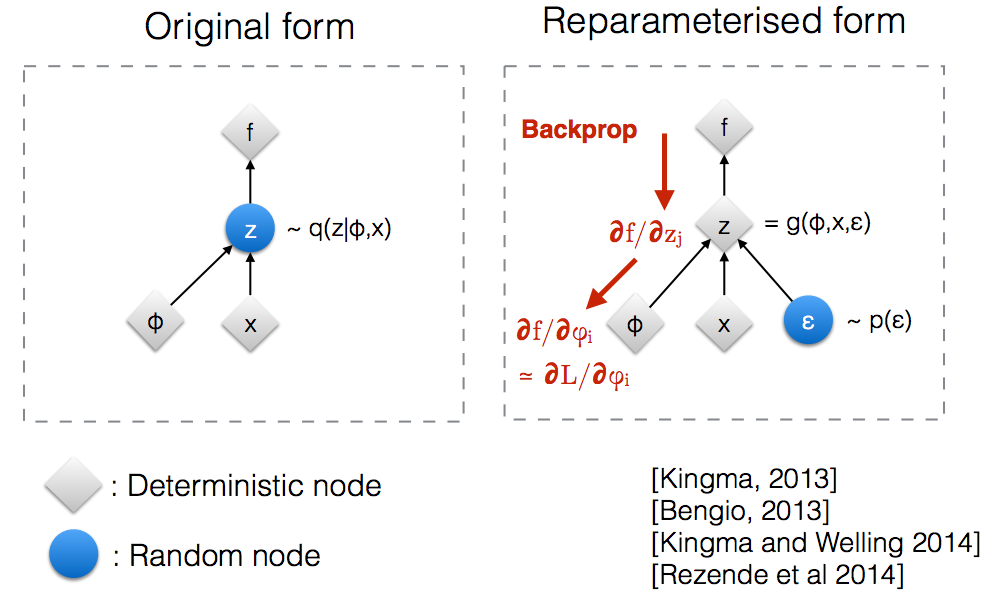

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import tnrange

torch.manual_seed(2017) # reproducability
%matplotlib inline

### Defining the Model

We use a four layer fully-connected architecture with ReLU activations . Note that the output of the Encoder has linear activations and is given by the vectors $\mu$ and $\log\sigma²$ since the latter is not restricted to be positive.

In [2]:
# Model
class VAE(nn.Module):
    def __init__(self,latent_dim=20,hidden_dim=500):
        super(VAE,self).__init__()
        self.fc_e = nn.Linear(784,hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        self.fc_d1 = nn.Linear(latent_dim,hidden_dim)
        self.fc_d2 = nn.Linear(hidden_dim,784)
            
    def encoder(self,x_in):
        x = F.relu(self.fc_e(x_in.view(-1,784)))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar
    
    def decoder(self,z):
        z = F.relu(self.fc_d1(z))
        x_out = torch.sigmoid(self.fc_d2(z))
        return x_out.view(-1,1,28,28)
    
    def sample_normal(self,mean,logvar):
        # Using torch.normal(means,sds) returns a stochastic tensor which we cannot backpropogate through.
        # Instead we utilize the 'reparameterization trick'.
        # http://stats.stackexchange.com/a/205336
        # http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf
        sd = torch.exp(logvar*0.5)
        e = Variable(torch.randn(sd.size())) # Sample from standard normal
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar

model = VAE()

In [3]:
# Loss function
def criterion(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0) # normalize by batch size
    return loss

In [4]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [5]:
# Data loaders
trainloader = DataLoader(
    MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdFcG9jaHMnLCBtYXg9MTAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGg9dSdpbmnigKY=


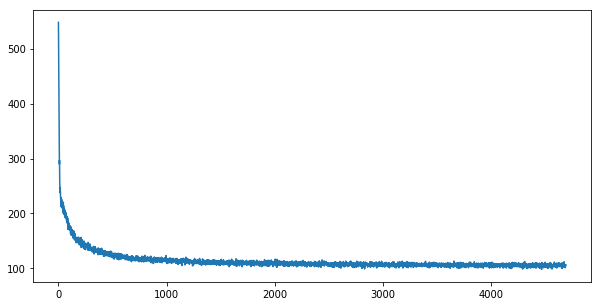

In [6]:
# Training
def train(model,optimizer,dataloader,epochs=10):
    losses = []
    for epoch in tnrange(epochs,desc='Epochs'):
        for images,_ in dataloader:
            x_in = Variable(images)
            optimizer.zero_grad()
            x_out, z_mu, z_logvar = model(x_in)
            loss = criterion(x_out,x_in,z_mu,z_logvar)
            loss.backward()
            optimizer.step()
            losses.append(loss.data)
    return losses

train_losses = train(model,optimizer,trainloader)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

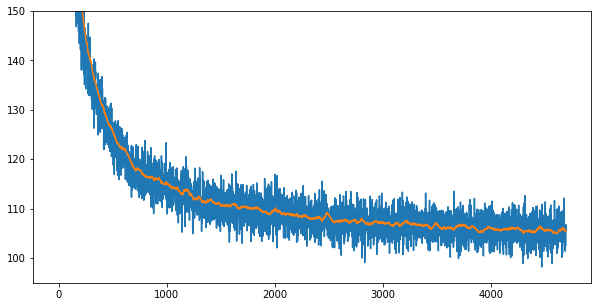

In [7]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid',ylim=(95,150)):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(train_losses)

In [8]:
# Testing
def test(model,dataloader):
    running_loss = 0.0
    for images, _ in dataloader:
        x_in = Variable(images)
        x_out, z_mu, z_logvar = model(x_in)
        loss = criterion(x_out,x_in,z_mu,z_logvar)
        running_loss = running_loss + (loss.data*x_in.size(0))
    return running_loss/len(dataloader.dataset)

test_loss = test(model,testloader)
print(test_loss)

tensor(104.9790)


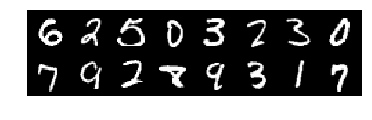

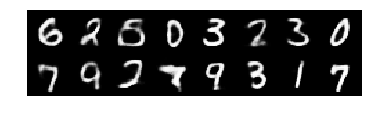

In [9]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = Variable(images)
    x_out,_,_ = model(x_in)
    x_out = x_out.data.cpu()
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model,testloader)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdFcG9jaHMnLCBtYXg9MzAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGg9dSdpbmnigKY=



tensor(150.4105)


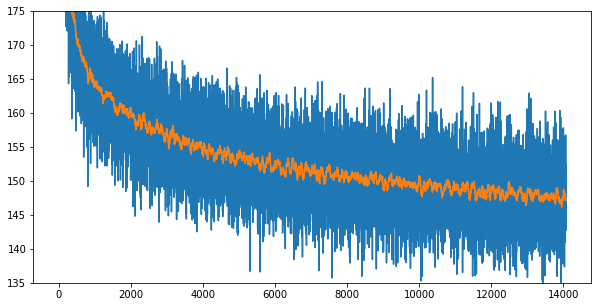

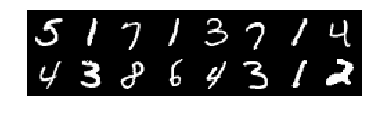

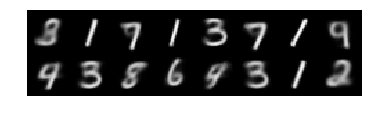

In [10]:
# Train, test and visualize reconstruction using a 2D latent space
model2 = VAE(latent_dim=2)
optimizer2 = torch.optim.Adam(model2.parameters())

train2_losses = train(model2,optimizer2,trainloader, epochs=30)
test2_loss = test(model2,testloader)

print(test2_loss)
visualize_losses_moving_average(train2_losses,ylim=(135,175))
visualize_mnist_vae(model2,testloader)

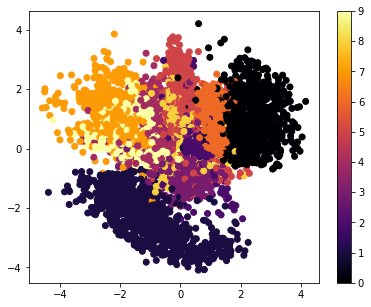

In [11]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    
    for images,labels in iter(dataloader):
        z_means,_ = model.encoder(Variable(images))
        z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
        z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
        all_labels = np.append(all_labels,labels.numpy())
        
    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(model2,testloader)

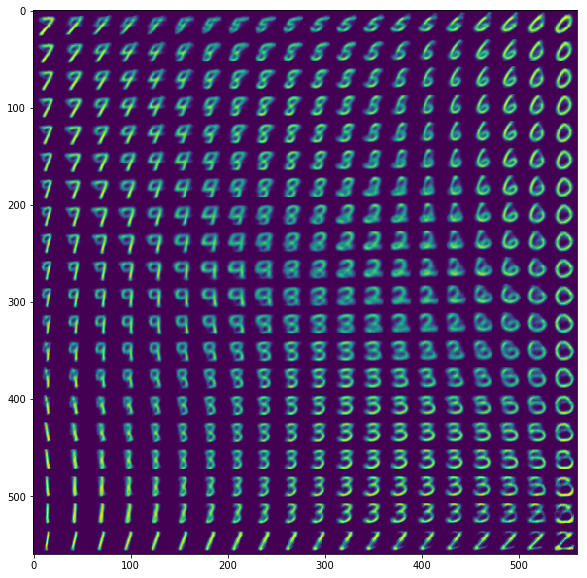

In [12]:
# Visualize digits generated from latent space grid
def visualize_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = Variable(torch.FloatTensor([[x,y]]))
            image = model.decoder(z)
            image = image.data.numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid)
    plt.show()

visualize_decoder(model2)